### 데이터 읽어오기

In [1]:
import glob
import os, re
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*' 
txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

### 데이터 정제

In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(f"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue
        
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
corpus[:5]

['<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>']

### 데이터셋 토큰화

In [3]:
import tensorflow as tf
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=12000,
                                                     filters=' ',
                                                     oov_token='<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post',
                                                          maxlen=20)
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   7 156 ...   0   0   0]
 [  2  17   7 ...   0   0   0]
 [  2   6  98 ...   0   0   0]
 ...
 [  2 310   1 ...   0   0   0]
 [  2 729   5 ...   0   0   0]
 [  2 729   5 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fee067d9100>


### 평가 데이터셋 분리

In [4]:
# source, target input 생성
src_input = tensor[:,:-1]
tgt_input = tensor[:, 1:]

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, 
                                                          test_size=0.2,
                                                         random_state=2023)

### train_dataset 객체 생성
---
<span style='color:red'> __BUFFER_SIZE 조절__ </span>
1. train_dataset 크기보다 10배 큰 값
2. train_dataset 크기보다 0.1배 작은 값
3. train_dataset 크기와 같은 값

* train_dataset의 BUFFER만 바꿈

In [5]:
print(len(enc_train))

139790


#### 1. train_dataset 크기보다 10배 큰 값

In [6]:
BUFFER_SIZE = 1397900
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

### val_dataset 객체 생성

In [7]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

### 모델 생성

In [8]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self,x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024 
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

### 모델 학습

In [9]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction='none')
model.compile(loss=loss, optimizer=optimizer)
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 134s 234ms/step - loss: 2.8875 - val_loss: 2.5750
Epoch 2/10
546/546 [==============================] - 131s 239ms/step - loss: 2.4863 - val_loss: 2.4294
Epoch 3/10
546/546 [==============================] - 131s 239ms/step - loss: 2.3526 - val_loss: 2.3348
Epoch 4/10
546/546 [==============================] - 131s 239ms/step - loss: 2.2524 - val_loss: 2.2686
Epoch 5/10
546/546 [==============================] - 131s 240ms/step - loss: 2.1679 - val_loss: 2.2148
Epoch 6/10
546/546 [==============================] - 131s 240ms/step - loss: 2.0908 - val_loss: 2.1706
Epoch 7/10
546/546 [==============================] - 131s 240ms/step - loss: 2.0190 - val_loss: 2.1301
Epoch 8/10
546/546 [==============================] - 131s 240ms/step - loss: 1.9509 - val_loss: 2.0984
Epoch 9/10
546/546 [==============================] - 131s 240ms/step - loss: 1.8850 - val_loss: 2.0689
Epoch 10/10
546/546 [==============================] - 131s 240m

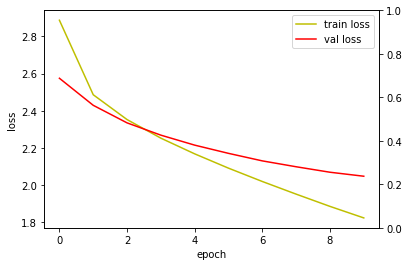

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

---

#### 2. train_dataset 크기보다 0.1배 작은 값

In [11]:
BUFFER_SIZE = 13979
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset2 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset2 = train_dataset2.shuffle(BUFFER_SIZE)
train_dataset2 = train_dataset2.batch(BATCH_SIZE, drop_remainder=True)
train_dataset2

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [12]:
history = model.fit(train_dataset2, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 149s 273ms/step - loss: 1.7632 - val_loss: 2.0272
Epoch 2/10
546/546 [==============================] - 286s 525ms/step - loss: 1.7064 - val_loss: 2.0107
Epoch 3/10
546/546 [==============================] - 258s 472ms/step - loss: 1.6510 - val_loss: 1.9976
Epoch 4/10
546/546 [==============================] - 258s 473ms/step - loss: 1.5969 - val_loss: 1.9862
Epoch 5/10
546/546 [==============================] - 294s 538ms/step - loss: 1.5444 - val_loss: 1.9779
Epoch 6/10
546/546 [==============================] - 294s 538ms/step - loss: 1.4938 - val_loss: 1.9717
Epoch 7/10
546/546 [==============================] - 294s 538ms/step - loss: 1.4447 - val_loss: 1.9694
Epoch 8/10
546/546 [==============================] - 294s 538ms/step - loss: 1.3973 - val_loss: 1.9657
Epoch 9/10
546/546 [==============================] - 294s 538ms/step - loss: 1.3512 - val_loss: 1.9665
Epoch 10/10
546/546 [==============================] - 294s 538m

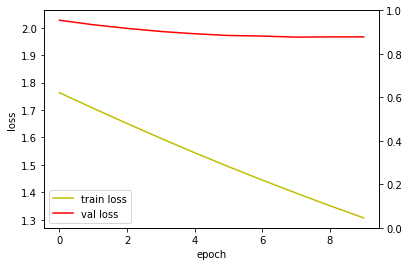

In [13]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

Buffer_size로 training dataset 개수보다 10배 작은 값을 사용했을 때, overfitting이 심하게 발생하는 것을 알 수 있음.

---

#### 3. train_dataset 크기와 같은 값

In [14]:
BUFFER_SIZE = 139790
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset3 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset3 = train_dataset3.shuffle(BUFFER_SIZE)
train_dataset3 = train_dataset3.batch(BATCH_SIZE, drop_remainder=True)
train_dataset3

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [15]:
history = model.fit(train_dataset3, epochs=10, validation_data=val_dataset)

Epoch 1/10
546/546 [==============================] - 227s 416ms/step - loss: 1.2699 - val_loss: 1.9640
Epoch 2/10
546/546 [==============================] - 275s 504ms/step - loss: 1.2271 - val_loss: 1.9694
Epoch 3/10
546/546 [==============================] - 276s 505ms/step - loss: 1.1864 - val_loss: 1.9725
Epoch 4/10
546/546 [==============================] - 276s 504ms/step - loss: 1.1485 - val_loss: 1.9779
Epoch 5/10
546/546 [==============================] - 276s 505ms/step - loss: 1.1112 - val_loss: 1.9866
Epoch 6/10
546/546 [==============================] - 275s 504ms/step - loss: 1.0769 - val_loss: 1.9955
Epoch 7/10
546/546 [==============================] - 258s 473ms/step - loss: 1.0436 - val_loss: 2.0037
Epoch 8/10
546/546 [==============================] - 275s 503ms/step - loss: 1.0127 - val_loss: 2.0173
Epoch 9/10
546/546 [==============================] - 275s 504ms/step - loss: 0.9828 - val_loss: 2.0237
Epoch 10/10
546/546 [==============================] - 275s 504m

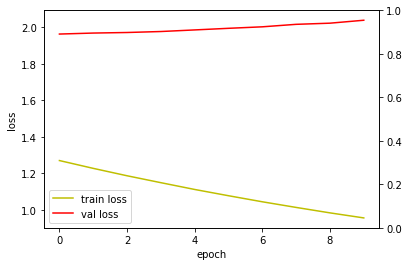

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
plt.show()

train_dataset 크기와 같은 값을 buffer_size로 설정한 경우에도 overfitting이 심하게 발생한 것을 알 수 있다.

train_dataset크기보다 큰 값을 buffer_size로 설정해야 데이터를 적절히 shuffle하여 ordering되어있거나 패턴화된 데이터를 가지고 학습할 수 있음을 알 수 있다.